# pyBKT Model Workshop - LAK

This is a tutorial that explores the basic features of pyBKT, ranging from model creation, fitting, prediction, evaluation and crossvalidation. We will be using the skills contained within the Cognitive Tutor and 2009-2010 Assistments datasets to demonstrate these features.

In [ ]:
# Install pyBKT from pip!
!pip uninstall -y pyBKT
!pip install pyBKT

# Import all required packages including pyBKT.models.Model!
import numpy as np
import pandas as pd
from pyBKT.models import Model
import matplotlib.pyplot as plt

     |████████████████████████████████| 28.2MB 125kB/s 
  Created wheel for pyBKT: filename=pyBKT-1.2.2-cp37-cp37m-linux_x86_64.whl size=1274124 sha256=0b62289aacbc3ed80420bdbf00d5f03167075d955c5a2d5c2bc388b9f2a9057e
  Stored in directory: /root/.cache/pip/wheels/55/73/5f/01ef3d2b8528b11ab932d7d00703df4517253482d23fae8cc3
Successfully built pyBKT


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


### Basic Model Creation and Evaluation

Initialize the model with an optional seed and number of fit initializations. Note that the Model constructor supports many more parameters such as the model variant (which can be modified at fit time), whether to parallelize computation, and more.

In [ ]:
# Note that the seed chosen is so we can consistently
# replicate the results and avoid as much randomness
# as possible.
model = Model(seed = 42, num_fits = 1, parallel  = True)

Fetch Assistments and CognitiveTutor data to the local disk. We will be using these datasets, but you can use any that you see fit when you use pyBKT. The data formats accepted by pyBKT are comma separated and tab separated files (note that pyBKT will automatically infer which is passed in). Note that the correctness is given by -1 (no response), 0 (incorrect), or 1 (correct).

In [ ]:
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/as.csv', '.')
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/ct.csv', '.')

We open the given datasets and explore them before using them to fit BKT models using pyBKT. Note that the column names describing the student ID, the problem name, the response's correctness and skill name all differ between the two datasets.

In [ ]:
ct_df = pd.read_csv('ct.csv', encoding = 'latin')
print(ct_df.columns)
ct_df.head(10)

Index(['Unnamed: 0', 'Row', 'Anon Student Id', 'Problem Hierarchy',
       'Problem Name', 'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)'],
      dtype='object')


,Unnamed: 0,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,1576,1927,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity1,2006-11-14 10:18:00.0,2006-11-14 10:18:05.0,2006-11-14 10:18:05.0,2006-11-14 10:18:05.0,5.00000,5.00000,nan,1,0,0,1,Calculate unit rate,1
1,1580,1931,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity2,2006-11-14 10:18:11.0,2006-11-14 10:18:17.0,2006-11-14 10:18:34.0,2006-11-14 10:18:34.0,23.00000,nan,23.00000,0,1,0,1,Calculate unit rate,2
2,1596,1947,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-012,1,SimplifiedNumeratorQuantity1,2006-11-14 10:50:52.0,2006-11-14 10:50:57.0,2006-11-14 10:51:11.0,2006-11-14 10:51:11.0,18.00000,nan,18.00000,0,1,0,1,Calculate unit rate,3
3,1597,1948,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-012,1,SimplifiedNumeratorQuantity2,2006-11-14 10:51:11.0,2006-11-14 10:51:14.0,2006-11-14 10:51:14.0,2006-11-14 10:51:14.0,3.00000,3.00000,nan,1,0,0,1,Calculate unit rate,4
4,1612,1963,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-054,1,SimplifiedNumeratorQuantity2,2006-11-28 09:53:43.0,2006-11-28 09:53:47.0,2006-11-28 09:53:56.0,2006-11-28 09:53:56.0,13.00000,nan,13.00000,0,1,0,1,Calculate unit rate,5
5,1615,1966,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-054,1,SimplifiedNumeratorQuantity1,2006-11-28 09:54:02.0,2006-11-28 09:54:14.0,2006-11-28 09:54:14.0,2006-11-28 09:54:14.0,12.00000,12.00000,nan,1,0,0,1,Calculate unit rate,6
6,1627,1978,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-029,1,SimplifiedNumeratorQuantity2,2006-11-28 10:17:17.0,2006-11-28 10:17:40.0,2006-11-28 10:17:40.0,2006-11-28 10:17:40.0,23.00000,23.00000,nan,1,0,0,1,Calculate unit rate,7
7,1630,1981,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-029,1,SimplifiedNumeratorQuantity1,2006-11-28 10:17:50.0,2006-11-28 10:18:06.0,2006-11-28 10:18:06.0,2006-11-28 10:18:06.0,16.00000,16.00000,nan,1,0,0,1,Calculate unit rate,8
8,1646,1997,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-109,1,SimplifiedNumeratorQuantity2,2006-11-28 10:44:49.0,2006-11-28 10:44:51.0,2006-11-28 10:44:51.0,2006-11-28 10:44:51.0,2.00000,2.00000,nan,1,0,0,1,Calculate unit rate,9
9,1647,1998,745Yh,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-109,1,SimplifiedNumeratorQuantity1,2006-11-28 10:44:51.0,2006-11-28 10:45:06.0,2006-11-28 10:45:06.0,2006-11-28 10:45:06.0,15.00000,15.00000,nan,1,0,0,1,Calculate unit rate,10


In [ ]:
as_df = pd.read_csv('as.csv', encoding = 'latin', low_memory = False)
print(as_df.columns)
as_df.head(5)

Index(['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id',
       'original', 'correct', 'attempt_count', 'ms_first_response',
       'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')


,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,answer_type,sequence_id,student_class_id,position,type,base_sequence_id,skill_id,skill_name,teacher_id,school_id,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,algebra,5948,13241,126,MasterySection,5948,1.00000,Box and Whisker,22763,73,0,3,32454,30799,nan,26,0,nan,1,1.00000
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,algebra,5948,13241,126,MasterySection,5948,1.00000,Box and Whisker,22763,73,0,3,4922,30799,nan,55,0,nan,2,2.00000
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,algebra,5948,11816,22,MasterySection,5948,1.00000,Box and Whisker,22763,73,0,3,42000,30799,nan,88,0,nan,1,1.00000
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,algebra,5948,11816,22,MasterySection,5948,1.00000,Box and Whisker,22763,73,0,3,4859,30059,nan,41,0,nan,2,2.00000
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,algebra,5948,11816,22,MasterySection,5948,1.00000,Box and Whisker,22763,73,3,4,124564,30060,nan,65,0,0.00000,3,3.00000


We can fit a simple BKT model with the `fit` method for the Model class. In this case, we will fit a BKT model to every skill in the Cognitive Tutor dataset separately. Note that when skill(s) are not specified, it trains a separate model on all skills by default.

We can either specify a data path (location of a file) or the Pandas DataFrame containing the data.

In [ ]:
model.fit(data_path = 'ct.csv')

We can train on multiple skills specified by a list of skill names or a 
REGEX match for each skill using the `skills` parameter. We demonstrate the usage of that below. In this case, we fit on all strings containing fraction.

In [ ]:
model.fit(data_path = 'ct.csv', skills = ".*fraction.*")
print("Fitted Skills:\n%s" % '\n'.join(model.coef_.keys()))

Fitted Skills:
Plot non-terminating improper fraction
Plot terminating proper fraction
Calculate part in proportion with fractions
Calculate total in proportion with fractions


Evaluate on the trained skills for any test data located in a Pandas DataFrame or in a file. In this case, we will just use training data, so this will display the training error. Note that the default metric displayed is RMSE. pyBKT supports AUC, RMSE, and accuracy
as metrics by default.

However, you can define your own custom metric as well!

In [ ]:
# Evaluate with the default RMSE then specify AUC.
model.fit(data_path = 'ct.csv')
training_rmse = model.evaluate(data = ct_df)
training_auc = model.evaluate(data_path = "ct.csv", metric = 'auc')
print("Training RMSE: %f" % training_rmse)
print("Training AUC: %f" % training_auc)

Training RMSE: 0.453674
Training AUC: 0.707657


In [ ]:
# We can even define our own metric!
def mae(true_vals, pred_vals):
  """ Calculates the mean absolute error. """
  return np.mean(np.abs(true_vals - pred_vals))

training_mae = model.evaluate(data_path = 'ct.csv', metric = mae)
print("Training MAE: %f" % training_mae)

Training MAE: 0.412162


### Model Prediction

pyBKT can return predictions on a test set given a Pandas DataFrame or a file conaining test data. If pyBKT is asked for predictions on skills for which it has not trained a model, it will output a best effort guess of 0.5 for both the correct and state predictions.

We will be using the training dataset again for testing purposes.

In [ ]:
# Note again that the REGEX expression below trains BKT models on all
# skills containing the word fraction!
model.fit(data_path = 'ct.csv', skills = ".*fraction.*")
preds = model.predict(data_path = 'ct.csv')
preds[['Anon Student Id', 'KC(Default)', 'Correct First Attempt', 
       'correct_predictions', 'state_predictions']].tail(5)

,Anon Student Id,KC(Default),Correct First Attempt,correct_predictions,state_predictions
2004,zt5vuLM,Calculate part in proportion with fractions,1,0.86000,0.00583
2005,zt5vuLM,Calculate total in proportion with fractions,1,0.77804,0.16313
2006,zt5vuLM,Calculate part in proportion with fractions,1,0.86171,0.00226
2007,zt5vuLM,Calculate total in proportion with fractions,1,0.84658,0.04482
2008,zt5vuLM,Calculate part in proportion with fractions,1,0.86237,0.00087


In [ ]:
# Let's sanity check that we have only trained on the skills that we 
# specified in the call to fit! Note that while it is possible for a 
# BKT prediction to be 0.5 exactly, it is unlikely.
preds[preds['correct_predictions'] != 0.5]['KC(Default)'].unique()

array(['Plot non-terminating improper fraction',
       'Plot terminating proper fraction',
       'Calculate part in proportion with fractions',
       'Calculate total in proportion with fractions'], dtype=object)

In [ ]:
# Let's manually calculate the RMSE of the correct predictions 
# and ensure that it is the same as a call to the evaluate function.
def rmse(y_true, y_pred):
  """ Returns the root-mean squared error. """
  return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Filter out the data for which we did not train!
preds_filtered = preds[preds['KC(Default)'].str.contains('fraction')]
manual_training_rmse = rmse(preds_filtered['Correct First Attempt'],
                            preds_filtered['correct_predictions'])
manual_training_rmse

0.44053077049006584

In [ ]:
# We use model.evaluate to accomplish the same thing!
# You should receive an RMSE that is identical to the above
# manually calculated RMSE.
model.evaluate(data = ct_df)

0.4405307704900611

### Question 1 (10 mins):

Fit your own BKT model below on the 'Calculate unit rate' skill from the Cognitive Tutor dataset on the provided training data. Evaluate the mean absolute error and AUC of predicting on the given test set and training set in the respective variables.

Note that we have already performed a train/test split below.

In [ ]:
# Test data proportion (i.e. 20% of all data used as testing data)
test_prop = 0.2

model = Model(seed = 42, num_fits = 1, parallel = True)
ct_data = ct_df[ct_df['KC(Default)'] == 
                'Calculate unit rate'].set_index('Anon Student Id')
idx_split = np.array(ct_data.index.unique())
np.random.seed(42)
np.random.shuffle(idx_split)
training_data = ct_data.loc[idx_split[int(test_prop * len(idx_split)):]]
test_data = ct_data.loc[idx_split[:int(test_prop * len(idx_split))]]

training_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)

training_mae, training_auc, test_mae, test_auc = 0, 0, 0, 0


In [ ]:
skill = 'Calculate unit rate'

model.fit(data = training_data, skills = skill)
model.evaluate(data = training_data)

preds = model.predict(data = test_data)

In [ ]:
preds[preds['correct_predictions'] != 0.5]['KC(Default)'].unique()

array(['Calculate unit rate'], dtype=object)

In [ ]:
training_mae = model.evaluate(data = training_data)
training_auc= model.evaluate(data = training_data, metric='auc')

test_mae = model.evaluate(data = test_data)
test_auc = model.evaluate(data = test_data, metric = 'auc')

In [ ]:
################ YOUR CODE HERE ################




################################################
print("Training Mean Absolute Error: %f" % training_mae)
print("Training AUC: %f" % training_auc)
print("Test Mean Absolute Error: %f" % test_mae)
print("Test AUC: %f" % test_auc)


training_data.head(5)

Training Mean Absolute Error: 0.479601
Training AUC: 0.614631
Test Mean Absolute Error: 0.493490
Test AUC: 0.553530


,Anon Student Id,Unnamed: 0,Row,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
3440,171017OL,1246625,1660187,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity1,2006-11-21 12:51:58.0,2006-11-21 12:52:02.0,2006-11-21 12:52:02.0,2006-11-21 12:52:02.0,4.00000,4.00000,nan,1,0,0,1,Calculate unit rate,1
3441,171017OL,1246635,1660197,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-001,1,SimplifiedNumeratorQuantity2,2006-11-21 12:52:35.0,2006-11-21 12:52:47.0,2006-11-21 12:55:15.0,2006-11-21 12:55:15.0,155.00000,nan,155.00000,0,4,1,1,Calculate unit rate,2
3442,171017OL,1246643,1660205,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-188,1,SimplifiedNumeratorQuantity1,2006-11-21 12:56:11.0,2006-11-21 12:57:01.0,2006-11-21 12:57:01.0,2006-11-21 12:57:01.0,50.00000,50.00000,nan,1,0,0,1,Calculate unit rate,3
3443,171017OL,1246650,1660212,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-188,1,SimplifiedNumeratorQuantity2,2006-11-21 12:57:16.0,2006-11-21 12:57:24.0,2006-11-21 12:57:24.0,2006-11-21 12:57:24.0,8.00000,8.00000,nan,1,0,0,1,Calculate unit rate,4
3444,171017OL,1246659,1660221,"Unit RATIO-PROPORTION, Section RATIO-PROPORTION-2",RATIO2-035,1,SimplifiedNumeratorQuantity1,2006-11-21 12:58:09.0,2006-11-21 12:58:24.0,2006-11-21 12:58:24.0,2006-11-21 12:58:24.0,15.00000,15.00000,nan,1,0,0,1,Calculate unit rate,5


### Model Cross-Validation and Variants

Crossvalidation is offered as a blackbox function similar to a combination of fit and evaluate that accepts a particular number of folds, a seed, and a metric (either one of the 3 provided that are 'rmse', 'auc' or 'accuracy' or a custom Python function taking 2 arguments). Similar arguments for the model types, data path/data, and skill names are accepted as with the fit function.

In [ ]:
# Note that folds is an optional parameter as well as the model 
# variant, seed, and crossvalidated metric.
# By default, we crossvalidate on all skills separately.
model.crossvalidate(data_path = 'ct.csv', folds = 5)

,rmse
skill,
Plot non-terminating improper fraction,0.48160
Plot imperfect radical,0.43714
Plot terminating proper fraction,0.49620
Plot pi,0.46048
Plot whole number,0.29062
Plot decimal - thousandths,0.47233
Calculate unit rate,0.48256
Calculate part in proportion with fractions,0.42730
Calculate total in proportion with fractions,0.42370


We explore all the model variants offered within pyBKT for one particular skill (Calculations with Similar Figures) using cross-validation since it provides a much better evaluation of true model performance during test time than the training loss!

In [ ]:
# Try this with a different skill or metric by replacing the lines below.
skill = 'Calculations with Similar Figures'
metric = 'auc'

simple_cv = model.crossvalidate(data = as_df, skills = skill, 
                                metric = metric)
simple_cv

,auc
skill,
Calculations with Similar Figures,0.59458


The multigs model fits a different guess/slip rate for each class. Note that by default, for the Assistments data, the guess and slip classes will be specified by the template_id. pyBKT will be able to infer the column names for AS/CT type datasets, but you can specify a custom column mapping (discussed in later cells).

In [ ]:
multigs_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                 multigs = True, metric = metric)
multigs_cv

,auc
skill,
Calculations with Similar Figures,0.67083


The multilearn model fits a different learn rate (and forget rate if enabled) rate for each class specified. Note that the learn classes are specified by the template_id column by default for the Assistments dataset.

In [ ]:
multilearn_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                    multilearn = True, forgets = True, 
                                    metric = metric)
multilearn_cv

,auc
skill,
Calculations with Similar Figures,0.65535


The multiprior model fits a different prior rate for the first response of a student sequence, and the multipair model generates a different learn rate based on each consecutive pair of classes. 

In [ ]:
# The multiprior model generates different priors based on the first 
# response of each student.
multiprior_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                    multiprior = True, metric = metric,
                                    folds = 3)
multipair_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                                   multipair = True, metric = metric,
                                   folds = 3)
pd.concat([multiprior_cv, multipair_cv], axis = 0)

,auc
skill,
Calculations with Similar Figures,0.59682
Calculations with Similar Figures,0.56483


The best performing models are typically those that combine several useful variants such as the multilearn and multiguess/slip class variants. We will enable the forgets parameter as well. Try testing with other skills and see whether this holds true for the general case.

In [ ]:
# We combine the fifth parameter, forgets, with the previous multilearn
# and multiguess/slip models for a combo model.
combo_cv = model.crossvalidate(data_path = 'as.csv', skills = skill,
                               forgets = True, multilearn = True, 
                               multigs = True, metric = metric)
combo_cv

,auc
skill,
Calculations with Similar Figures,0.69301


### Question 2 (10 mins):

Which combination of model variants has the smallest crossvalidated loss for "Venn Diagram"? Which model variant is the best performant with a minimal number of parameters? Use the root-mean squared error as the metric.

,rmse
model type,
simple,0.33122
multilearn,0.32798
multipair,0.32538
multigs,0.30675
forgets,0.28320
multigs + forgets,0.27044
multilearn + forgets,0.27226


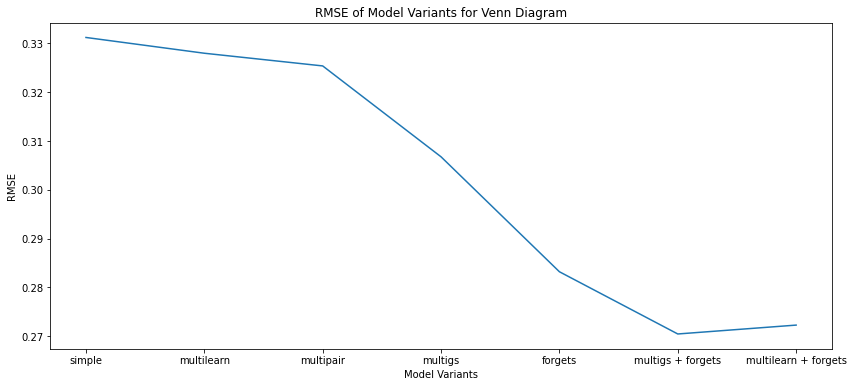

In [ ]:
models = {}

model = Model(seed = 42, num_fits = 5, parallel = True)

skill = 'Venn Diagram'
################ YOUR CODE HERE ################
models['simple'] = model.crossvalidate(data_path = 'as.csv', skills = skill)
models['multilearn'] = model.crossvalidate(data_path = 'as.csv', skills = skill, multilearn = True)
models['multipair'] = model.crossvalidate(data_path = 'as.csv', skills = skill, multipair = True)
models['multigs'] = model.crossvalidate(data_path = 'as.csv', skills = skill, multigs = True)
models['forgets'] = model.crossvalidate(data_path = 'as.csv', skills = skill, forgets = True)
models['multigs + forgets'] = model.crossvalidate(data_path = 'as.csv', skills = skill, multigs = True, forgets = True)
models['multilearn + forgets'] = model.crossvalidate(data_path = 'as.csv', skills = skill, multilearn = True, forgets = True)
# Are there any more models you can think of?

################################################

df = pd.concat(models.values())
df['model type'] = models.keys()
plt.figure(figsize = (14, 6))
plt.plot(df['model type'], df['rmse'])
plt.title('RMSE of Model Variants for Venn Diagram')
plt.ylabel('RMSE')
plt.xlabel('Model Variants')
df.set_index('model type')

### Model Parameter Initialization and Visualization

We can initialize any of the model parameters for a particular skill's BKT model before training using `model.coef_`. Similar to SciKit Learn, `model.coef_` is a way to initialize model parameters and view them after they are fitted.


In [ ]:
# We initialize the prior parameter to 1e-3 for the Box and Whisker 
# skill.
#
# Note that if we are training a KT-IDEM (multiguess/slip) model,
# we need to have len(guesses) == len(slips) == # of G/S classes.
# Similarly, for multilearn models, you need len(forgets) == len(guesses)
# corresponding to the number of learn classes.
skill = 'Box and Whisker'

model.coef_ = {skill: {'prior': 1e-40}}
model.coef_

{'Box and Whisker': {'prior': 1e-40}}

In [ ]:
# Train the model with the pre-initialized parameters.
model.fit(data_path = 'as.csv', skills = skill, multigs = True)
low_prior_auc = model.evaluate(data_path = 'as.csv', metric = 'auc')

# We can obtain the prior value by indexing into the model.coef_
# dictionary with the skill and parameter names. 
print("Fitted Prior Value: %f" % model.coef_[skill]['prior'])
print("Training AUC: %f" % low_prior_auc)

Fitted Prior Value: 0.000000
Training AUC: 0.611076


In [ ]:
# Initialize the prior to be more reasonable.
model.coef_ = {skill: {'prior': 0.5}}
model.fit(data_path = 'as.csv', skills = skill, multigs = True)
normal_prior_auc = model.evaluate(data_path = 'as.csv', metric = 'auc')

# Print the fitted prior value and RMSE.
print("Fitted Prior Value: %f" % model.coef_[skill]['prior'])
print("Training AUC: %f" % normal_prior_auc)

Fitted Prior Value: 0.747623
Training AUC: 0.643520


We can visualize the parameters of our fitted model in a Pandas DataFrame once it has been fit. We can easily plot the learn, forget, guess, and slip rates for multilearn/forget and multiguess/slip models. 

In [ ]:
model.fit(data_path = 'as.csv', skills = skill,
          forgets = True, multilearn = True, 
          multigs = True)
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.65117
                learns  30059   0.34441
                        30060   0.09922
                        30799   0.36158
                        63446   0.00253
                        63447   0.21696
                        63448   0.14994
                guesses 30059   0.38968
                        30060   0.51943
                        30799   0.01284
                        63446   0.50579
                        63447   0.00007
                        63448   0.53070
                slips   30059   0.06858
                        30060   0.27694
                        30799   0.06797
                        63446   0.18020
                        63447   0.13073
                        63448   0.14436
                forgets 30059   0.00000
                        30060   0.03582
                        30799   0.00594
                        63446   0.02147
                        63447   0.05391
                        63448   0.00037

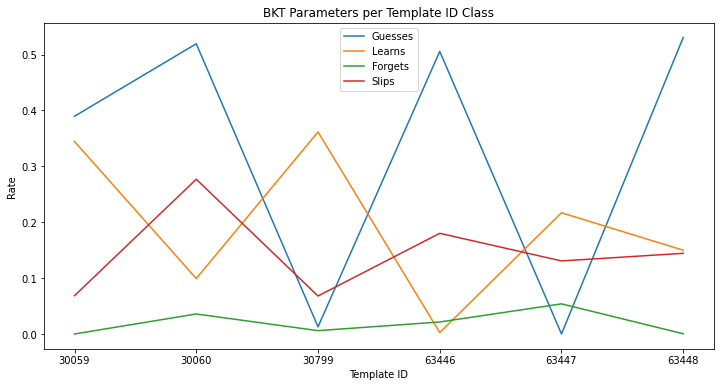

In [ ]:
# We will get warnings for using indexing past lexsort. That's fine,
# and we will disable these warnings.
import warnings
warnings.simplefilter(action='ignore')

# Plot the learns, forgets, slips and guesses for each of the classes.
params = model.params()
plt.figure(figsize = (12, 6))
plt.plot(params.loc[(skill, 'guesses')], label = 'Guesses')
plt.plot(params.loc[(skill, 'learns')], label = 'Learns')
plt.plot(params.loc[(skill, 'forgets')], label = 'Forgets')
plt.plot(params.loc[(skill, 'slips')], label = 'Slips')
plt.xlabel('Template ID')
plt.ylabel('Rate')
plt.title('BKT Parameters per Template ID Class')
plt.legend();

### Extended Data and Model Configuration

Models can get excessively long, whether it's due to the number of model variants used, the number of folds/seed/metric for crossvalidation, data path length, etc.

We create a configuration dictionary that describes all the parameters we will pass in. Note that this is not a pyBKT feature, but actually just a Python feature that not many realize is very powerful!

In [ ]:
config = {'multigs': True,
          'multilearn': True,
          'skills': ['Box and Whisker', 'Circle Graph'],
          'forgets': True,
          'metric': 'accuracy',
          'folds': 4,
          'seed': 42 * 42}
model.crossvalidate(data_path = 'as.csv', **config)

,accuracy
skill,
Circle Graph,0.68536
Box and Whisker,0.76240


For other non-Assistments/CogTutor style datasets, we will need to specify the
columns corresponding to each required column (i.e. the user ID, correct/incorrect). This is because pyBKT only supports the automatic inference of column names for the AS/CT datasets.

For that, we use a defaults dictionary or specify parameters for each model variant.

In [ ]:
# Note that this means that the order_id specified by the column named
# custom_order in our custom dataset, the skill_name is specified by the 
# custom_skill column in our custom dataset, and so on.
defaults = {'order_id': 'custom_order', 
            'skill_name': 'custom_skill', 
            'correct': 'custom_answer'}

# This defaults dictionary can also contain columns specifying
# what columns correspond to the desired guess/slip classes, etc.
defaults['multigs'] = 'custom_gs_classes'

# Our final column mapping is:
defaults

{'correct': 'custom_answer',
 'multigs': 'custom_gs_classes',
 'order_id': 'custom_order',
 'skill_name': 'custom_skill'}

In [ ]:
# We'll use this mapping with the modified CogTutor dataset with the names
# we chose for the columns.
#
# Note that Row is the order ID (order_id), KC(Default) is the 
# skill name (skill_name), Correct First Attempt is correct, and 
# Problem Name is the corresponding guess/slip class column.

columns = ['Row', 'Anon Student Id', 'KC(Default)', 
           'Correct First Attempt', 'Problem Name']
my_df = ct_df[columns]
my_df.columns = ['custom_order', 'Anon Student Id',
                 'custom_skill', 'custom_answer',
                 'custom_gs_classes']
my_df['custom_skill'] += ' (Custom)'
my_df.head(5)

,custom_order,Anon Student Id,custom_skill,custom_answer,custom_gs_classes
773,112149,0I891Gg,Plot non-terminating improper fraction (Custom),0,RATIONAL1-014
774,112151,0I891Gg,Plot imperfect radical (Custom),0,RATIONAL1-041
775,112156,0I891Gg,Plot terminating proper fraction (Custom),0,RATIONAL1-104
776,112157,0I891Gg,Plot pi (Custom),1,RATIONAL1-122
777,112159,0I891Gg,Plot terminating proper fraction (Custom),1,RATIONAL1-180


In [ ]:
# We can crossvalidate/fit given these default column mappings.
model.crossvalidate(data = my_df, metric = 'auc',
                    defaults = defaults)

,auc
skill,
Plot non-terminating improper fraction (Custom),0.64856
Plot imperfect radical (Custom),0.64157
Plot terminating proper fraction (Custom),0.56842
Plot pi (Custom),0.57536
Plot whole number (Custom),0.53885
Plot decimal - thousandths (Custom),0.62655
Calculate unit rate (Custom),0.60277
Calculate part in proportion with fractions (Custom),0.67047
Calculate total in proportion with fractions (Custom),0.70902


### Exploratory Questions

#### Question 1:

Does response time have an effect on the learn rate?
Does discretized response time as a learn class improve the RMSE of the model compared to the normal `template_id` based multilearn and multiguess/slip models?

Experiment with different discrete response time bins. You may want to start with defining learn classes according to response times less than 10 seconds and greater than 10 seconds.

*Hint:* How can you use floor division to create your learn classes? `df.map(dict)` can help map values to other values as given in `dict`.

In [ ]:
custom_df = as_df.copy()

In [ ]:
custom_df['response_time'] = np.where(custom_df['ms_first_response'] < 10000, '(Fast)', '(Slow)')
# custom_df['skill_name'] = custom_df['skill_name']+' '+custom_df['response_time']

In [ ]:
custom_df

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,answer_type,sequence_id,student_class_id,position,type,base_sequence_id,skill_id,skill_name,teacher_id,school_id,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original,Fast_responce
3957,21617623,263599,14,53412,93383,1,0,1,26271,tutor,algebra,7118,12495,1,MasterySection,7118,2.00000,Circle Graph (Slow),42972,1,2,2,41131,52570,nan,NaN,1,1.00000,1,1.00000,(Slow)
172411,21617623,263599,14,53412,93383,1,0,1,26271,tutor,algebra,7118,12495,1,MasterySection,7118,70.00000,Percent Of (Slow),42972,1,2,2,41131,52570,nan,NaN,1,1.00000,1,1.00000,(Slow)
94047,21617623,263599,14,53412,93383,1,0,1,26271,tutor,algebra,7118,12495,1,MasterySection,7118,37.00000,NaN,42972,1,2,2,41131,52570,nan,NaN,1,1.00000,1,1.00000,(Slow)
172412,21617632,263599,14,53436,93407,1,1,1,29123,tutor,algebra,7118,12495,1,MasterySection,7118,70.00000,Percent Of (Slow),42972,1,0,2,29123,52570,nan,82.8,0,nan,2,2.00000,(Slow)
94048,21617632,263599,14,53436,93407,1,1,1,29123,tutor,algebra,7118,12495,1,MasterySection,7118,37.00000,NaN,42972,1,0,2,29123,52570,nan,82.8,0,nan,2,2.00000,(Slow)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157250,38214250,291501,96299,32147,49290,1,1,1,20281,tutor,fill_in_1,5924,14415,8,MasterySection,5924,58.00000,Addition Whole Numbers (Slow),69274,2770,0,4,20281,30336,nan,182,0,nan,1,1.00000,(Slow)
157251,38214251,291501,96299,32141,49284,1,1,1,24313,tutor,fill_in_1,5924,14415,8,MasterySection,5924,58.00000,Addition Whole Numbers (Slow),69274,2770,0,4,24313,30336,nan,196,0,nan,2,2.00000,(Slow)
157252,38214252,291501,96299,32133,49276,1,1,1,46547,tutor,fill_in_1,5924,14415,8,MasterySection,5924,58.00000,Addition Whole Numbers (Slow),69274,2770,0,4,46547,30336,nan,177,0,nan,3,3.00000,(Slow)
397273,38214256,291485,96299,32983,51180,1,1,1,39813,tutor,algebra,5946,14415,33,MasterySection,5946,309.00000,"Order of Operations +,-,/,* () positive reals ...",69274,2770,0,3,39813,29981,nan,393,0,nan,2,2.00000,(Slow)


In [ ]:
model = Model(seed = 42, num_fits = 1, parallel = True)

################ YOUR CODE HERE ################

config = {'multigs': True,
          'multilearn': 'response_time',
          'skills': ".*Graph.*",
          'forgets': True,
          'metric': 'rmse',
          'folds': 4,
          'seed': 42 * 42}
model.crossvalidate(data = custom_df, **config)

################################################
model.params()

value
skill                                           param   class          
Solving Systems of Linear Equations by Graphing prior   default 0.75613
                                                learns  (Fast)  0.00000
                                                        (Slow)  0.00159
                                                guesses 59998   0.00000
                                                        60008   0.00000
                                                        60010   0.75443
                                                slips   59998   0.62937
                                                        60008   0.66006
                                                        60010   0.04209
                                                forgets (Fast)  0.00000
                                                        (Slow)  0.02217

In [ ]:
model.crossvalidate(data = custom_df, **config)

,rmse
skill,
Circle Graph,0.45341
Interpreting Coordinate Graphs,0.58591
Histogram as Table or Graph,0.44193
Write Linear Equation from Graph,0.46876
Solving Systems of Linear Equations by Graphing,0.36482


In [ ]:
config = {'multigs': True,
          'multilearn': True,
          'skills': ".*Graph.*",
          'forgets': True,
          'metric': 'rmse',
          'folds': 4,
          'seed': 42 * 42}
model.crossvalidate(data = as_df, **config)

,rmse
skill,
Circle Graph,0.45539
Interpreting Coordinate Graphs,0.58591
Histogram as Table or Graph,0.44855
Write Linear Equation from Graph,0.47499
Solving Systems of Linear Equations by Graphing,0.37436


#### Question 2:

Which custom columns work the best for the multilearn BKT model for the skills listed below in `ct.csv`? Which are the worst performing? Evaluate using the AUC and use the basic BKT model as a baseline.

In [ ]:
skills = ['Calculate unit rate',
          'Calculate part in proportion with fractions']
column_names = ["Anon Student Id", "Problem Hierarchy", "Problem Name", 
                "Problem View", "Step Name", "Correct First Attempt", 
                "Incorrects", "Hints", "Opportunity(Default)"]
model = Model(seed = 42, num_fits = 1)

################ YOUR CODE HERE ################




################################################

#### Question 3:

Fit a multiguess/slip model to 2 skills of your choice. Create a visualization of their guess parameters for each skill. What are the differences in their distribution?

A preliminary suggestion for 2 skills to compare are `Calculate unit rate` and `Calculate part in proportion with fractions` since they contain the most unique values of `template_id`.

In [ ]:
# We will get warnings for using indexing past lexsort. That's fine,
# and we will disable these warnings.
import warnings
warnings.simplefilter(action='ignore')

model = Model(seed = 42, num_fits = 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 6))

################ YOUR CODE HERE ################

# Make sure to plot the first figure to ax1 and the
# second to ax2.
skill1 = 'Calculate part in proportion with fractions'
skill2 = 'Calculate unit rate'




################################################


### Summary

The following is a summary of most of the key features of BKT.

In [ ]:
# Let's summarize.
def mae(true_vals, pred_vals):
  """ Calculates the mean absolute error. """
  return np.mean(np.abs(true_vals - pred_vals))

# This code fetches data, fits, predicts, evaluates and crossvalidates
# a BKT model on all skills in Cognitive Tutor. It uses the mean absolute
# error as the desired error metric.
model = Model(seed = 42, num_fits = 5)
model.fit(data_path = 'ct.csv')
preds_df = model.predict(data_path = 'ct.csv')
mae_error = model.evaluate(data_path = 'ct.csv', metric = mae)
cv_errors = model.crossvalidate(data_path = 'ct.csv', metric = mae)
params_df = model.params()
print("Training MAE: %f" % mae_error)
cv_errors